# English to Igbo Language Sports Headlines Translation Project
## Sequence-to-sequence learning
### Neural machine translation with a Tensorflow Transformer

In this project, I applied the TensorFlow-Keras Transformer model to translate English 'Complete Sports' Headlines into Igbo. The transformer model is implemented based on the paper. <a href='https://arxiv.org/abs/1706.03762'>Attention is all you need. </a>

<b>Objective: </b> To learn and demonstrate my understanding of the transformer model.

<b>Data: </b> The sports headlines were scrapped from the Complete Sports <a href='https://www.completesports.com/'>English</a> and <a href='https://www.completesports.com/ig/'>Igbo</a> websites.  

<i>Tutorial adapted from <a href='https://www.tensorflow.org/text/tutorials/transformer'>Tensorflow</a> and <a href='https://machinelearningmastery.com/building-transformer-models-with-attention-crash-course-build-a-neural-machine-translator-in-12-days/'>Machine learning mastery</a></i>


#### The Transformer - Model Architecture

<img src="img1.png" alt="image" width="65%" height="auto"></img>

In [1]:
#import packages
import tensorflow as tf
import pickle
import random
import re
import unicodedata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Load and process the data

In [2]:
# import the data
#df = pd.read_csv('/content/drive/MyDrive/igbo_eng_headlines/igbo_eng_headlines_data.csv')
df = pd.read_csv('igbo_eng_headlines_data.csv')

In [3]:
#View a few samples
df.sample(7)

,Igbo,English
2518,Portugal FA gakwuru Mourinho maka ọzụzụ otu eg...,Portugal FA Approach Mourinho Over National Te...
8500,Cristiano Ronaldo nwalere ihe ọma maka Coronav...,Cristiano Ronaldo Tests Positive For Coronavirus
10038,Ụbọchị egwuregwu Bundesliga 15: Bayern Target ...,Bundesliga Matchday 15: Bayern Target Winning ...
10333,Garba chọsiri ike iduga Eaglets gaa n'isi nke ...,Garba Eager To Lead Eaglets To 6th U-17 World ...
9758,Rohr: 'Winger ihe atụ Kalu ga-aka mma' Maka Ug...,Rohr: ‘Examplary Winger Kalu Will Come Better’...
3580,WAFCON 2022: South Africa tozuru oke maka ngwụ...,WAFCON 2022: South Africa Qualify For Final Af...
11546,Ihe nleba anya nke gbara agba nke 28 nke La Li...,La Liga Round 28 Preview: Alaves Can Cut Gap T...


In [4]:
df.Igbo[:7].values

array(['Onye isi Chelsea Pochettino enweela nkụda mmụọ na ha gbara megide Bournemouth',
       'Disasi: Atala ndị Fans Chelsea ụta maka ịkwa anyị ụta',
       'Onye nkuzi Milan Pioli ga-ezute ndị isi ọgbakọ ka 5-1 meriri Inter',
       "EPL: 'Imeri dị mkpa' -Sanchez na-ekwu okwu n'ihu Bournemouth Vs Chelsea",
       'Jota: Liverpool nwere ike ịlụso Man City ọgụ maka aha Premier League',
       'Man United debere ndekọ Premier League achọghị ka emeri Brighton',
       'EPL: Onyeka dị ka Newcastle United Pip Brentford'], dtype=object)

In [5]:
print(f'We have {df.shape[0]} examples to work with')

We have 17963 examples to work with


In [6]:
#extract length of the sequences before applying the normalization
df['mx_ig'] = df['Igbo'].map(lambda x: len(x.split()))
df['mx_en'] = df['English'].map(lambda x: len(x.split()))

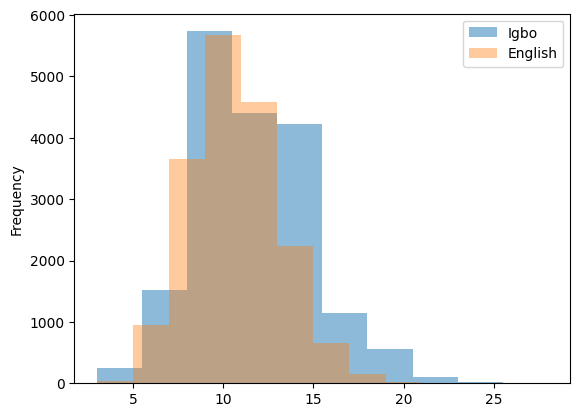

In [7]:
#plot the distribnution of Igbo/English sequence lengths
df['mx_ig'].plot(kind='hist', alpha=0.5)
df['mx_en'].plot(kind='hist', alpha=0.4)
plt.legend({'Igbo', 'English'});

In [8]:
#Text Normalization - (Code from www.machinelearnningmastery.com)
#define function to normalise igbo text using unicodedata NFKC normal form
# and also use regex to add space around puntuation marks
# convert the text to lower case
def normalize(eng, igbo):

    """Normalize igbo text using unicodedata NFKC"""
    line = eng + '\t' + igbo
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, igbo = line.split("\t")
    igbo = "[start] " + igbo + " [end]"

    return eng, igbo

In [9]:
#Apply text normalization
eng_igb=[]
for i, rows in df.iterrows():
    eng_igb.append(normalize(df.English.values[i], df.Igbo.values[i]))

In [10]:
#view a few samples
eng_igb[:10]

[('chelsea boss pochettino disappointed with draw against bournemouth',
  '[start] onye isi chelsea pochettino enweela nkụda mmụọ na ha gbara megide bournemouth [end]'),
 ('disasi : don’t blame chelsea fans for booing us',
  '[start] disasi : atala ndị fans chelsea ụta maka ịkwa anyị ụta [end]'),
 ('milan coach pioli to meet with club directors after 5-1 defeat to inter',
  '[start] onye nkuzi milan pioli ga-ezute ndị isi ọgbakọ ka 5-1 meriri inter [end]'),
 ('epl :  ‘ winning is important ’  – sanchez speaks ahead bournemouth vs chelsea',
  "[start] epl :  ' imeri dị mkpa '  - sanchez na-ekwu okwu n'ihu bournemouth vs chelsea [end]"),
 ('jota : liverpool can fight man city for premier league title',
  '[start] jota : liverpool nwere ike ịlụso man city ọgụ maka aha premier league [end]'),
 ('man united set unwanted premier league record after defeat to brighton',
  '[start] man united debere ndekọ premier league achọghị ka emeri brighton [end]'),
 ('epl : onyeka subbed on as newcastle 

In [11]:
#count the number of tokens in each pair
eng_tokens, igbo_tokens = set(), set() #Since this is a set, we get only unique values. No duplicates
eng_maxlen, igbo_maxlen = 0, 0

for eng, igbo in eng_igb:
    eng_token, igbo_token = eng.split(), igbo.split()
    eng_maxlen = max(eng_maxlen, len(eng_token)) #compares each length if longer than current maxlenght gets assigned to max length
    igbo_maxlen = max(igbo_maxlen, len(igbo_token))
    eng_tokens.update(eng_token) #updates the set with unique values
    igbo_tokens.update(igbo_token)

print(f'Total English tokens -> {len(eng_tokens)}')
print(f'Total Igbo tokens -> {len(igbo_tokens)}')
print(f'Max English length -> {eng_maxlen}')
print(f'Max Igbo length -> {igbo_maxlen}')
print(f'Total length of text pairs -> {len(eng)}')

Total English tokens -> 10973
Total Igbo tokens -> 10187
Max English length -> 31
Max Igbo length -> 33
Total length of text pairs -> 63


In [12]:
#Shuffle the data
random.shuffle(eng_igb)
eng_igb[:2]

[('cape verde referee duarte to officiate nigeria , lesotho afcon qualifier',
  '[start] cape verde referee duarte ga-achị naịjirịa , lesotho afcon qualifier [end]'),
 ('2023 u-20 afcon : how we beat flying eagles  — senegal captain , diallo',
  '[start] 2023 u-20 afcon : otu anyị si merie flying eagles  - onye isi senegal , diallo [end]')]

In [13]:
#cut down the data for testing the pipieline
sample_size = 1 #set to 1 to use the entire dataset
data_size = int(len(eng_igb) * sample_size)
print(f'The sample size is {data_size}')

The sample size is 17963


In [14]:
#Split the data into 80/10/10 Train/Val/Test
train_size = 0.8
val_size = 0.1

#Get a subset of the data
data_pairs = eng_igb[:data_size]

#Extract train, test and validation
train_data = data_pairs[:int(train_size * data_size)]
val_data = data_pairs[int(train_size * data_size):int(train_size * data_size) + int(val_size * data_size)]
test_data  = data_pairs[int(train_size * data_size) + int(val_size * data_size):]

print(f'The size of the train data - {len(train_data)}')
print(f'The size of the validation data - {len(val_data)}')
print(f'The size of the test data - {len(test_data)}')

The size of the train data - 14370
The size of the validation data - 1796
The size of the test data - 1797


In [15]:
#Check the sizes of the datasets all add up
assert(data_size==len(train_data) + len(val_data) + len(test_data))

In [16]:
# Get the size of the english and Igbo vocubulary
vocab_size_en = len(eng_tokens) + 1
vocab_size_ig = len(igbo_tokens) + 1
seq_length = max(eng_maxlen, igbo_maxlen)
print(f'The maximum sequence length -> {seq_length}')

The maximum sequence length -> 33


In [17]:
# Create Textvectorizer
eng_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
igb_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size_ig,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)

In [18]:
# train the vectorization layer using training dataset
train_eng_texts = [pair[0] for pair in train_data] #extracts the english headline
train_igb_texts = [pair[1] for pair in train_data] #extracts the igbo headline
eng_vectorizer.adapt(train_eng_texts)
igb_vectorizer.adapt(train_igb_texts)

In [19]:
# save for subsequent steps
with open("vectorize_desktop.pickle", "wb") as fp:
    data = {
        "train": train_data,
        "val":   val_data,
        "test":  test_data,
        "engvec_config":  eng_vectorizer.get_config(),
        "engvec_weights": eng_vectorizer.get_weights(),
        "igbvec_config":  igb_vectorizer.get_config(),
        "igbvec_weights": igb_vectorizer.get_weights(),
    }
    pickle.dump(data, fp)

In [20]:
#View the vectorizer config
#The gets the parameters that were set in the previous step
eng_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 10974,
 'standardize': None,
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 33,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 10003}

## Test the Dataset

In [21]:
# load text data and vectorizer weights
#with open("/content/drive/MyDrive/igbo_eng_headlines/vectorize_desktop.pickle", "rb") as fp:
    #data = pickle.load(fp)

In [22]:
# set up Dataset object
def format_dataset(eng, igb):
    """Take an English and a Igbo sentence pair, convert into input and target.

    """
    eng = eng_vectorizer(eng)
    igb = igb_vectorizer(igb)
    source = (eng, igb[:, :-1])
    target = igb[:, 1:]
    
    return (source, target)

In [23]:
#Sample to see how the vectorizer works
x = test_data[1][0]
x

'2022 wcq : rohr’s 24-man list must be respected  – udeze'

In [24]:
#basically converts the sequence into vectors the length of the sequence length parameter
x = eng_vectorizer(x)
x

<tf.Tensor: shape=(33,), dtype=int64, numpy=
array([  39,  113,    2,  570, 3468,  734,   71,   45, 4574,   11,  913,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>

In [25]:
def make_dataset(pairs, batch_size=16):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, igb_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(igb_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16)

In [26]:
#Get the dataset
train_ds = make_dataset(train_data)
val_ds = make_dataset(val_data)

In [27]:
# test the dataset
#for inputs, targets in train_ds.take(1):
  #print(inputs)
  #print(targets)

## Define the positional encoding

In [28]:
def positional_encoding(length, depth):

    depth = depth//2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

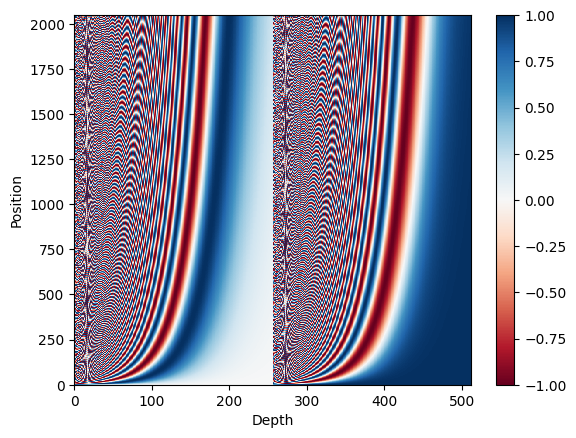

In [29]:
# Plot the positional encoding matrix
pos_matrix = positional_encoding(2048, 512)
assert pos_matrix.shape == (2048, 512)
plt.pcolormesh(pos_matrix, cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Create the Positional Embedding Layer

In [30]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = x.shape[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        
        return x

In [31]:
# test the dataset
for inputs, targets in train_ds.take(1):
    print(inputs[0].shape) #View the shape of the input encoder
    print(inputs[1].shape) #view the shape of input decoder
    embed_en = PositionalEmbedding(vocab_size_en, d_model=512) #An instance of the PositionalEmbedding class
    en_emb = embed_en(inputs[0])
    print(en_emb.shape) #view the shape of the positional encoding applied to the input encoder


(16, 33)
(16, 33)
(16, 33, 512)


In [32]:
embed_ig = PositionalEmbedding(vocab_size_ig, d_model=512)
embed_en = PositionalEmbedding(vocab_size_en, d_model=512)

en_emb = embed_en(inputs[0])
ig_emb = embed_ig(inputs[1])

#apply the mask
#print(en_emb._keras_mask)

## Add and Normalize
Implemented with the LayerNormalization layer

## The base attention layer
This attention layer is for each component layer

In [33]:
class BaseAttention(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

## Cross Attention Layer
This layer connects the endoder and decoder

In [34]:
class CrossAttention(BaseAttention):
    
    def call(self, x, context):
        attn_output = self.mha(
           query=x,
           key=context,
           value=context)

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [35]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(ig_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, ig_emb).shape)

(16, 33, 512)
(16, 33, 512)
(16, 33, 512)


## The global self attention layer

In [36]:
class GlobalSelfAttention(BaseAttention):
    
    def call(self, x):
        attn_output = self.mha(
        query=x,
        value=x,
        key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

In [37]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_gsa(en_emb).shape)

(16, 33, 512)
(16, 33, 512)


## The causal self attention layer
Does the same as the global self attention layer for the output sequence

In [38]:
class CausalSelfAttention(BaseAttention):
    
    def call(self, x):
        attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

In [39]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(ig_emb.shape)
print(sample_csa(ig_emb).shape)

(16, 33, 512)
(16, 33, 512)


In [40]:
out1 = sample_csa(embed_en(inputs[0][:, :3]))
out2 = sample_csa(embed_en(inputs[1]))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

2.9134963

## The feed forward network

In [41]:
class FeedForward(tf.keras.layers.Layer):
    
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
                   tf.keras.layers.Dense(dff, activation='relu'),
                   tf.keras.layers.Dense(d_model),
                   tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        
        return x


In [42]:
#Check the shape from the feed forward layer 
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(16, 33, 512)
(16, 33, 512)


## Encoder Layer

In [43]:
class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
                              num_heads=num_heads,
                              key_dim=d_model,
                              dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        
        return x


In [44]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(en_emb.shape)
print(sample_encoder_layer(en_emb).shape)

(16, 33, 512)
(16, 33, 512)


The encoder consists of:

    * A PositionalEmbedding layer at the input.
    * A stack of EncoderLayer layers.


In [45]:
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model,num_heads=num_heads,dff=dff,
                                        dropout_rate=dropout_rate)
                                        for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
        x = self.dropout(x)# Add dropout.

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.


In [46]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,d_model=512,num_heads=8,dff=2048,vocab_size=11000)

sample_encoder_output = sample_encoder(inputs[0], training=False)

# Print the shape.
print(inputs[0].shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.


(16, 33)
(16, 33, 512)


## The Decoder Layer

In [47]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*,d_model,num_heads,dff,dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
                                     num_heads=num_heads,
                                     key_dim=d_model,
                                     dropout=dropout_rate)

        self.cross_attention = CrossAttention(
                               num_heads=num_heads,
                               key_dim=d_model,
                               dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        
        return x

### Test the decoder layer

In [48]:
#Test the decoder
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output = sample_decoder_layer(x=en_emb, context=ig_emb)

print(en_emb.shape)
print(ig_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`


(16, 33, 512)
(16, 33, 512)
(16, 33, 512)


## The Decoder

In [49]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, 
                    *, 
                    num_layers, 
                    d_model, 
                    num_heads, 
                    dff, 
                    vocab_size,
                    dropout_rate=0.1):
            super(Decoder, self).__init__()

            self.d_model = d_model
            self.num_layers = num_layers

            self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                 d_model=d_model)
            self.dropout = tf.keras.layers.Dropout(dropout_rate)
            self.dec_layers = [DecoderLayer(d_model=d_model, 
                                            num_heads=num_heads,
                                            dff=dff, 
                                            dropout_rate=dropout_rate)
                                            for _ in range(num_layers)]
            self.last_attn_scores = None

    def call(self, x, context):
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)
        
        return x


In [50]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocab_size_ig)

output = sample_decoder(x=inputs[1],context=ig_emb)

# Print the shapes.
print(inputs[1].shape)
print(ig_emb.shape)
print(output.shape)

(16, 33)
(16, 33, 512)
(16, 33, 512)


# The Transformer

We put the encoder and decoder together with a dense layer

In [51]:
class Transformer(tf.keras.Model):
    def __init__(self, 
                    *, 
                    num_layers, 
                    d_model, 
                    num_heads, dff,
                    input_vocab_size, 
                    target_vocab_size, 
                    dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, 
                               d_model=d_model,
                               num_heads=num_heads, 
                               dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, 
                               d_model=d_model,
                               num_heads=num_heads, 
                               dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        context, x  = inputs
        context = self.encoder(context)  # (batch_size, context_len, d_model)
        x = self.decoder(x, context)  # (batch_size, target_len, d_model)
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

## Hyperparameters

In [52]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
epochs = 100

In [53]:
transformer = Transformer(
              num_layers=num_layers,
              d_model=d_model,
              num_heads=num_heads,
              dff=dff,
              input_vocab_size=vocab_size_en,
              target_vocab_size=vocab_size_ig,
              dropout_rate=dropout_rate)

In [54]:
output = transformer((inputs[0], inputs[1]))

print(inputs[0].shape)
print(inputs[1].shape)
print(output.shape)


(16, 33)
(16, 33)
(16, 33, 10188)


In [55]:
#attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
#print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

In [56]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  4043520   
                                                                 
 decoder_1 (Decoder)         multiple                  6053888   
                                                                 
 dense_38 (Dense)            multiple                  1314252   
                                                                 
Total params: 11411660 (43.53 MB)
Trainable params: 11411660 (43.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training

In [57]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, 
                 d_model, 
                 warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [58]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

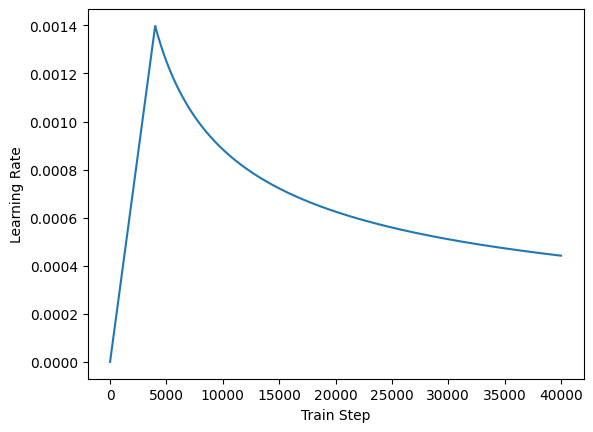

In [59]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step');

# Set up the loss and metrics

In [60]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    mask = label != 0
    match = match & mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
  
    return tf.reduce_sum(match)/tf.reduce_sum(mask)


# Train the model

In [61]:
transformer.compile(loss=masked_loss,
            optimizer=optimizer,
            metrics=[masked_accuracy])


In [62]:
transformer.fit(train_ds,
                epochs=epochs,
                validation_data=val_ds)

Epoch 1/100
899/899 [==============================] - 148s 162ms/step - loss: 7.0078 - masked_accuracy: 0.1206 - val_loss: 5.4762 - val_masked_accuracy: 0.2398
Epoch 2/100
899/899 [==============================] - 153s 170ms/step - loss: 4.6357 - masked_accuracy: 0.3337 - val_loss: 3.9768 - val_masked_accuracy: 0.4247
Epoch 3/100
899/899 [==============================] - 158s 176ms/step - loss: 3.5390 - masked_accuracy: 0.4700 - val_loss: 3.2881 - val_masked_accuracy: 0.5103
Epoch 4/100
899/899 [==============================] - 157s 174ms/step - loss: 2.9971 - masked_accuracy: 0.5354 - val_loss: 2.9685 - val_masked_accuracy: 0.5535
Epoch 5/100
899/899 [==============================] - 155s 172ms/step - loss: 2.6924 - masked_accuracy: 0.5697 - val_loss: 2.7067 - val_masked_accuracy: 0.5799
Epoch 6/100
899/899 [==============================] - 155s 172ms/step - loss: 2.3234 - masked_accuracy: 0.6149 - val_loss: 2.4661 - val_masked_accuracy: 0.6214
Epoch 7/100
899/899 [=============

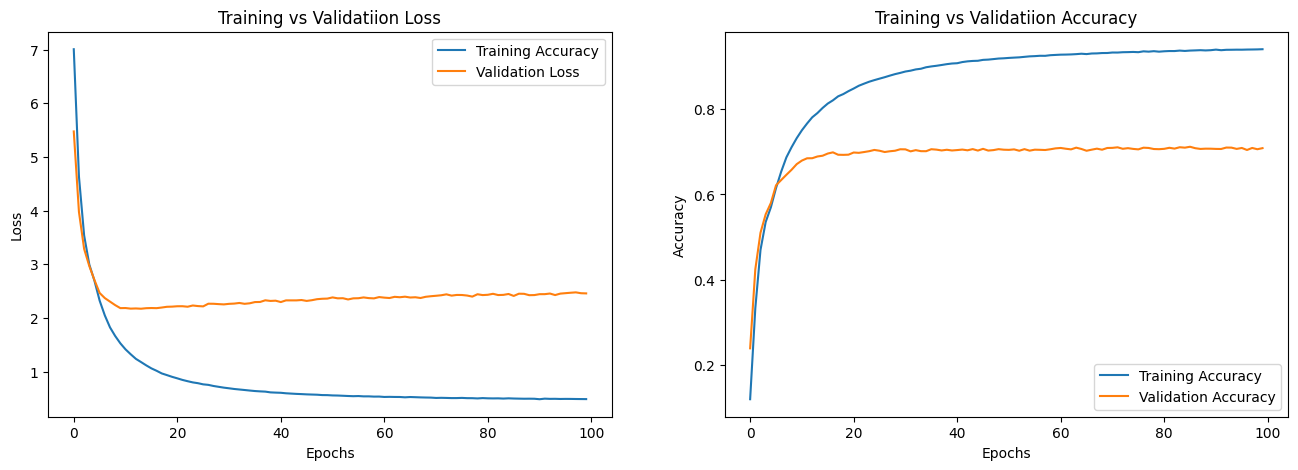

In [63]:
#plot the model evaluation metrics
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(transformer.history.history['loss'])
plt.plot(transformer.history.history['val_loss'])
plt.legend(['Training Accuracy','Validation Loss'])
plt.title('Training vs Validatiion Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.subplot(1,2,2)
plt.plot(transformer.history.history['masked_accuracy'])
plt.plot(transformer.history.history['val_masked_accuracy'])
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Training vs Validatiion Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [64]:
#transformer.history.history

In [65]:
#save model weights
transformer.save_weights("model_2")

## Test the Model

In [66]:
class Translator(tf.Module):
    def __init__(self, transformer):
        self.transformer = transformer

    def __call__(self, sentence, transformer, seq_len):

        #Create the translated sentence
        enc_tokens = eng_vectorizer([sentence])
        lookup = list(igb_vectorizer.get_vocabulary())
        start_sentence, end_sentence = "[start]", "[end]"
        output_sentence = [start_sentence]


        for i in range(seq_len):
            vector = igb_vectorizer([" ".join(output_sentence)])
            assert vector.shape == (1, seq_len+1)
            dec_tokens = vector[:, :-1]
            assert dec_tokens.shape == (1, seq_len)
            pred = transformer([enc_tokens, dec_tokens])
            assert pred.shape == (1, seq_len, vocab_size_ig)
            word = lookup[np.argmax(pred[0, i, :])]
            output_sentence.append(word)

            if word == end_sentence:
                break


        return output_sentence


In [67]:
def generate_translation(test_data, translator, seq_length):
    
    english_sentence, igbo_sentence = random.choice(test_data)
    translated_sentence = translator(english_sentence, transformer, seq_length)
    
    return english_sentence, igbo_sentence, translated_sentence

In [68]:
translator = Translator(transformer)

test_count = 50

for i in range(test_count):
    english_sentence, igbo_sentence, translated_sentence = generate_translation(test_data, translator, seq_length)
    
    print(f"Example {i}:")
    print(f"English ->{english_sentence}")
    print(f"Ground Truth ->{igbo_sentence}")
    print(f"Translation ->{' '.join(translated_sentence)}")
    print()

Example 0:
English ->man utd played a good game against arsenal  – ten hag
Ground Truth ->[start] man utd gbara arsenal ezigbo egwuregwu  - ten hag [end]
Translation ->[start] man utd bụ ezigbo egwuregwu megide arsenal - ten hag [end]

Example 1:
English ->nigeria vs zambia : mikel agu to hit super eagles camp on sunday
Ground Truth ->[start] naijiria vs zambia : mikel agu ga-akụ super eagles camp ụbọchị ụka [end]
Translation ->[start] nigeria vs zambia : mikel agu ga-eji kụrụ ogige super eagles na sọnde [end]

Example 2:
English ->aina hails solid hull city win vs burton albion
Ground Truth ->[start] aina hails solid hull city meriri burton albion [end]
Translation ->[start] aina kelere hull city siri ike imeri vs forest na doncaster [end]

Example 3:
English ->el clasico : benzema doubtful for real madrid vs barcelona
Ground Truth ->[start] el clasico : benzema nwere obi abụọ maka real madrid vs barcelona [end]
Translation ->[start] el clasico : benzema nwere obi abụọ maka real madri

## Reference
1. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L. and Polosukhin, I.
Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L. and Polosukhin, I. (2023) Attention Is All You Need, arXiv.org. Available at: https://arxiv.org/abs/1706.03762.
2. Tam, A. (2023) Building Transformer Models with Attention Crash Course. Build a Neural Machine Translator in 12 Days, MachineLearningMastery.com. Available at: https://machinelearningmastery.com/building-transformer-models-with-attention-crash-course-build-a-neural-machine-translator-in-12-days/ (Accessed: 9 November 2023).
3. Neural machine translation with a Transformer and Keras  :  Text  :  TensorFlow (no date) TensorFlow. Available at: https://www.tensorflow.org/text/tutorials/transformer (Accessed: 9 November 2023).